# <img src="assets/ufscar.png" alt="Logo UFScar" width="200" align="left"/><p><center>Universidade Federal de São Carlos (UFSCar)</center><br/><font size="4"><center> Departamento de Computação, campus Sorocaba </center> </font>


<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>
</p>

<br>
<font size = "4"><center><b> Grupo 5: Análise de sentimento de reviews na Amazon </b></center></font>
<br>

# Recurrent Neural Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pre_processing as pp
import analysis as anl
import pca

# Categoria da base de dados a ser lida (do disco) e processada
# [books, kitchen_&_housewares, electronics, dvd, all]
category = 'test'

# Se positivo, adiciona bigramas para reviews negativas
# ex: ('not', 'good') equivale a uma única feature
hNeg = True

# Se positivo, adiciona substantivos
noun = False

# Guarda as features ja processadas em X, a classe da amostra em Y e o vocabulario em vocabulary
# hNeg e noun sao opcionais, por padrao hNeg=True, noun=False
X, Y, vocabulary = pp.bow(category, hNeg, noun)

print("Vocabulário possui " + str(len(vocabulary)) + " palavras!")

Vocabulário possui 1509 palavras!


#### Separa os dados em treinamento e teste:

In [2]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X2, Y2 = X[idx_perm, :], Y[idx_perm]

# Porcentagem de amostras destinadas a base de treino
pTrain = 0.8

# Executa o holdout e retorna os indices de treino e teste, mantendo a proporcao original entre as classes
train_index, test_index = anl.stratified_holdOut(Y, pTrain)

# Guarda as amostras de treino e teste
Xtrain, Xval = X2[train_index, :], X2[test_index, :]
Ytrain, Yval = Y2[train_index], Y2[test_index]

#### Seleciona features com chi-quadrado (a partir dos dados de treinamento):

In [3]:
# Seta o valor de alpha para o chi-quadrado. 
# alpha e opcional, por padrão alpha = 0.05
alpha = 0.05

# Chama a funcao para executar o chi-quadrado e retorna a nova base de dados reduzida
# o novo vocabulario e os indices das features mantidas
Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary, alpha)

# Seleciona apenas as features do indice retornado pelo chi-quadrado para a base de teste
Xval = Xval[:, index]

# Converte matrizes esparsas para np arrays, para os cálculos da rede neural
Xtrain = Xtrain.toarray()
Xval = Xval.toarray()

In [4]:
print("Número de features antes do chi-quadrado: " + str(len(vocabulary)))
print("----------------------------------------")
print("Número de features após chi-quadrado: " + str(len(new_vocabulary)))
print(new_vocabulary)

Número de features antes do chi-quadrado: 1509
----------------------------------------
Número de features após chi-quadrado: 26


#### Função auxiliar para calcular a Função Sigmóide:

In [5]:
def sigmoid(z):
    
    """
    Calcula a funcao sigmoidal  
    """
    # Verifica se z e inteiro
    if isinstance(z, int):
        g = 0
    
    # se z não é um inteiro, significa que é um array e inicia com a dimensão do array
    else:
        g = np.zeros( z.shape );

    # Calculo vetorial da funcao sigmoidal
    g = 1/(1 + np.exp(-z))
  
    return g

#### Função auxiliar para calcular a derivada da Função Sigmóide:

In [6]:
def sigmoidGradient(z):

    g = np.zeros(z.shape)
    g = sigmoid(z)*(1 - sigmoid(z))    

    return g

#### Função auxiliar para calcular a Função Custo:

In [7]:
import scipy.optimize

def funcaoCusto_backp(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, flagreg = False,lambda_reg = 1):
    
    # Extrai os parametros de nn_params e alimenta as variaveis Theta1 e Theta2.
    Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
    Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )

    # Qtde de amostras
    m = X.shape[0]
         
    # Custo
    J = 0
    
    # Theta das redes neurais
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    # Constante para evitar erro de precisao numerica
    eps = 1e-15

    # Seta os rotulos como verdadeiro apenas para a classe da amostra
    rotulos = np.zeros((len(y), num_labels), dtype=int) 
    for i in range(len(rotulos)):
        rotulos[i][y[i]] = 1

    # Calcula os nos da camada oculta
    a1 = np.insert(X, 0, np.ones(m, dtype=int), axis=1)
    z2 = np.dot(a1, Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, np.ones(a2.shape[0], dtype=int), axis=1)
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    
    
    delta3 = a3 - rotulos
    delta2 = np.dot(delta3, Theta2[:, 1:]) * sigmoidGradient(z2)

    if flagreg == True :
        reg = (lambda_reg/(2*m))*(np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2)) 

        J += reg

        Theta1_grad[:, 0] = (np.dot(delta2.T, a1)[:, 0]/m) 
        Theta1_grad[:, 1:] = (np.dot(delta2.T, a1)[:, 1:]/m) + (lambda_reg/m)*Theta1[:, 1:]

        Theta2_grad[:, 0] = (np.dot(delta3.T, a2)[:, 0]/m) 
        Theta2_grad[:, 1:] = (np.dot(delta3.T, a2)[:, 1:]/m) + (lambda_reg/m)*Theta2[:, 1:]
    
    else:    
        Theta1_grad = np.dot(delta2.T, a1)/m
        Theta2_grad = np.dot(delta3.T, a2)/m
     
    J = np.sum(-rotulos*np.log(a3+eps) - (1 - rotulos)*np.log(1 - a3+eps))/m

    grad = np.concatenate([np.ravel(Theta1_grad), np.ravel(Theta2_grad)])

    return J, grad

#### Função auxiliar para predizer um conjunto de amostras:

In [8]:
def predicao(Theta1, Theta2, Xval, Yval):

    m = Xval.shape[0] # número de amostras
    num_labels = Theta2.shape[0]
    
    p = np.zeros(m)

    a1 = np.hstack( [np.ones([m,1]), Xval] )
    h1 = sigmoid( np.dot(a1, Theta1.T) )

    a2 = np.hstack( [np.ones([m,1]), h1] ) 
    h2 = sigmoid( np.dot(a2,Theta2.T) )
    
    Ypred = np.argmax(h2,axis=1)
    
    acuracia = np.sum(Ypred==Yval)/len(Yval)   
        
    return Ypred, acuracia

### Gridsearch: 
Itera sobre uma lista de possíveis valores para lambda_reg e retorna o melhor

In [9]:
def gridSearch(X, Y ,Xval, Yval):
    
    lambda_rnn = [0.01, 0.1, 10, 100]
    
    bestLambda = lambda_rnn[0]
    bestAcc = 0
    
    for l in lambda_rnn:
        # Treina e retorna os thetas
        Theta1, Theta2 = redes_neurais(Xtrain, Ytrain, l)
        
        # Realiza a predição e guarda os resultados e a acuracia
        Ypred, acuracia = predicao(Theta1, Theta2, Xval, Yval)
        if bestAcc < acuracia :
            bestLambda = l
            bestAcc = acuracia
        
    return bestLambda

## Treinamento RNN:
Minimiza o custo da rede neural, retornando vetores de thetas ótimos.

In [10]:
def redes_neurais (Xtrain, Ytrain, lambda_rnn, maxIter = 500):

    input_layer_size  = Xtrain.shape[1]  # 20x20 dimensao das imagens de entrada
    hidden_layer_size = int((input_layer_size + 2)*2/3)   
    num_labels = 2          # 10 rotulos, de 1 a 10  
                         #  (observe que a classe "0" recebe o rotulo 10)
    epsilon_init = 0.12
    
    # carregando os pesos da camada 1
    Theta1 =  np.random.RandomState(10).rand(hidden_layer_size, 1 + input_layer_size) * 2 * epsilon_init - epsilon_init
    
    # carregando os pesos da camada 2
    Theta2 = np.random.RandomState(10).rand(num_labels, 1 + hidden_layer_size) * 2 * epsilon_init - epsilon_init
    
    # concatena os pesos em um único vetor
    initial_rna_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])
    
    #lamba_reg = 1
    
    # Minimiza a funcao de custo
    result = scipy.optimize.minimize(fun=funcaoCusto_backp, x0=initial_rna_params, args=(input_layer_size, hidden_layer_size, num_labels, Xtrain, Ytrain,True,lambda_rnn),  
                    method='TNC', jac=True, options={'maxiter': maxIter})
    
    # Coleta os pesos retornados pela função de minimização
    nn_params = result.x
    
    # Obtem Theta1 e Theta2 back a partir de rna_params
    Theta1 = np.reshape( nn_params[0:hidden_layer_size*(input_layer_size + 1)], (hidden_layer_size, input_layer_size+1) )
    Theta2 = np.reshape( nn_params[ hidden_layer_size*(input_layer_size + 1):], (num_labels, hidden_layer_size+1) )
    
    return Theta1, Theta2

#### Predição da base de teste do Holdout:

In [11]:
lambda_rnn = gridSearch(Xtrain, Ytrain, Xval, Yval)
Theta1, Theta2 = redes_neurais(Xtrain, Ytrain, lambda_rnn, maxIter = 500)

Ypred, acuracia = predicao(Theta1, Theta2, Xval, Yval)
print("Acurácia é "+ str(acuracia*100))

classes = np.unique(Y)
auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

Acurácia é 68.75

	Revocacao   Precisao   F-medida   Classe
	0.625       0.714      0.667      0
	0.750       0.667      0.706      1
	------------------------------------------------
	0.688       0.690      0.689      Média macro
	0.688       0.688      0.688      Média micro

	Acuracia: 0.688


## Curva de Aprendizado:

In [12]:
def curva_aprendizado(X, Y, Xval, Yval, lambda_rnn, num_iteracoes = 0):
   
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
    
    lambda_rnn : fator de regularização da função de custo
    
    num_iteracoes : escalar indicando a quantidade de iterações da curva de aprendizado
  
    """

    # Define a quantidade de iteracoes, por padrao, itera por cada amostra da base de treino
    if (num_iteracoes <= 0 or num_iteracoes > len (Y)):
        num_iteracoes = len (Y)
    
    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # Guarda a quantidade de classes da base
    classes = np.unique(Y)
    
    # Itera e executa a Rede Neural com i amostras da base de treino para cada iteracao
    for i in range(10, len(Y), int (len(Y)/num_iteracoes)):
        # Executa o treinamento e retorna os thetas
        Theta1, Theta2 = redes_neurais(X[:i], Y[:i], lambda_rnn)

        # Realiza a predição usando a base de treino e retorna a acuracia e as classes preditas
        Ypred, acuracia = predicao(Theta1, Theta2, X[:i], Y[:i])
        
        # Guarda a acuracia da iteracao usando a base de treino como teste
        perf_train.append(acuracia)

        # Realiza a predição usando a base de teste e retorna a acuracia e as classes preditas
        Ypred, acuracia = predicao(Theta1, Theta2, Xval, Yval)
        
        # Guarda a acuracia da iteracao usando a base de validacao como teste
        perf_val.append(acuracia)


    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()

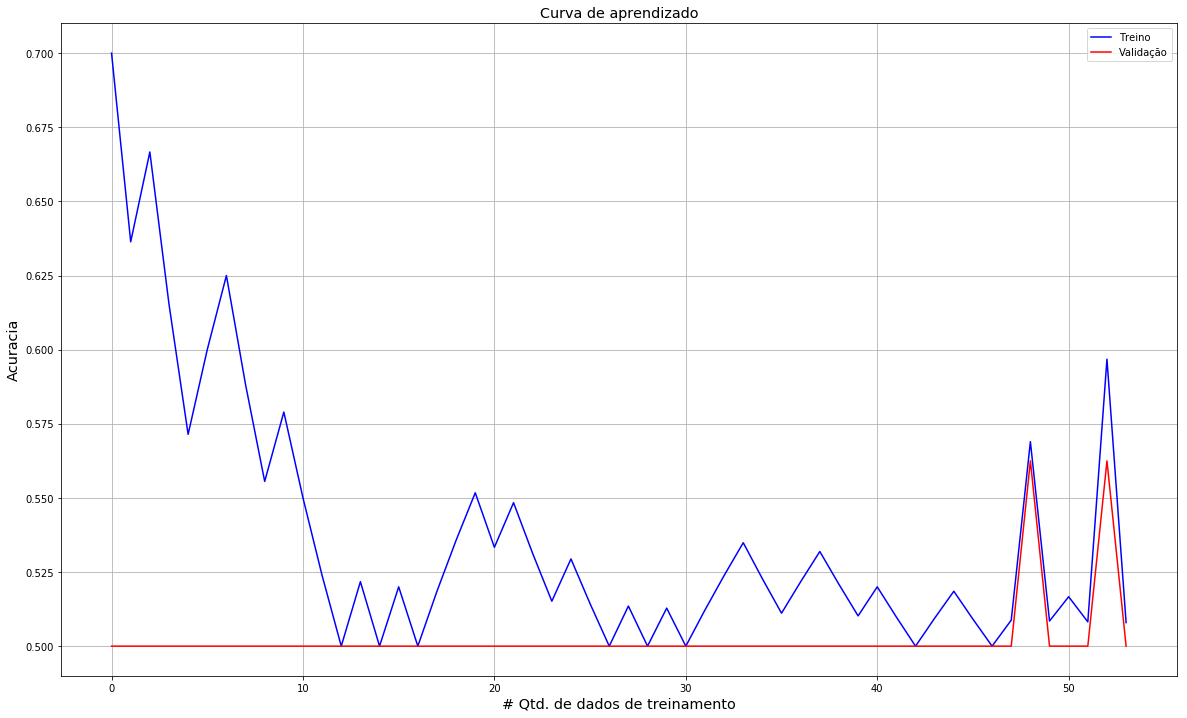

In [13]:
# lambda_rnn = fator de regularizacao da rede neural
# num_iteracoes = numero de iteracoes da curva de aprendizado, por padrao e igual ao numero de amostras da base
lambda_rnn = 10
curva_aprendizado(Xtrain, Ytrain, Xval, Yval, lambda_rnn, num_iteracoes = 100)

In [14]:
import k_folds as kf

#Pega todos os tipos de classes 
classes = classes = np.unique(Y)

# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X3, Y3 = X[idx_perm, :], Y[idx_perm]

# separa os dados em k folds
nFolds = 5
folds = kf.stratified_kfolds(Y3, nFolds, classes)

k = 1

# cria uma lista vazia para guardar os resultados obtidos em cada fold
resultados=[] 

for train_index, test_index in folds:

    print('\n-----------\n%d-fold: \n-----------\n' % (k) )

    # se train_index ou test_index forem vazios, interrompe o laco de repeticao
    if len(train_index)==0 or len(test_index)==0: 
        print('\tErro: o vetor com os indices de treinamento ou o vetor com os indices de teste esta vazio')      
        break
        
    # Guarda as bases de treino e teste baseado nos índices de cada fold
    Xtrain, Xval = X3[train_index, :], X3[test_index, :];
    Ytrain, Yval= Y3[train_index], Y3[test_index];

    # Executa o chi-quadrado na base do fold atual
    Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary)
    Xval = Xval[:, index]
    
    #Converte matrizes esparsas para np arrays, para os cálculos da rede neural
    Xtrain = Xtrain.toarray()
    Xval = Xval.toarray()
    
    # Executa o gridSearch e retorna o melhor fator de regularizacao 
    lambda_rnn = gridSearch(Xtrain, Ytrain, Xval, Yval)
    
    # Executa o treinamento e guarda os thetas
    Theta1, Theta2 = redes_neurais(Xtrain, Ytrain, lambda_rnn)
    
    # Faz a predicao
    Ypred, acuracia = predicao(Theta1, Theta2, Xval, Yval)
    
    print("Melhor lambda")
    print(lambda_rnn)
    
    # Relatorio do fold
    auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

    # adiciona os resultados do fold atual na lista de resultados
    resultados.append( auxResults )
    
    k = k + 1
    
kf.mediaFolds( resultados, classes )


-----------
1-fold: 
-----------

Melhor lambda
0.1

	Revocacao   Precisao   F-medida   Classe
	0.750       0.750      0.750      0
	0.778       0.778      0.778      1
	------------------------------------------------
	0.764       0.764      0.764      Média macro
	0.765       0.765      0.765      Média micro

	Acuracia: 0.765

-----------
2-fold: 
-----------

Melhor lambda
0.01

	Revocacao   Precisao   F-medida   Classe
	0.500       0.500      0.500      0
	0.500       0.500      0.500      1
	------------------------------------------------
	0.500       0.500      0.500      Média macro
	0.500       0.500      0.500      Média micro

	Acuracia: 0.500

-----------
3-fold: 
-----------

Melhor lambda
0.01

	Revocacao   Precisao   F-medida   Classe
	0.750       0.667      0.706      0
	0.625       0.714      0.667      1
	------------------------------------------------
	0.688       0.690      0.689      Média macro
	0.688       0.688      0.688      Média micro

	Acuracia: 0.688

-